# It's Time to Go:  
## A final project on simulating something "like electrons and positrons"

## Objectives:

* Gain familiarity with simulating quantum systems through trotterization
* Using all your accrued skills, implement a novel code on a real device
* Perform statistical analysis on noisy data

This lab is a vain attempt to extend some of the work performed in BLARG to actual machines. I have tried to inject this with as much of the real feel of doing work on quantum algorithms today as possible.  

## The Model: 1+1d $Z_2$ gauge theory with staggered fermionic matter

To remember the picture, and the qubit assignments
![z2_cart.png](attachment:z2_cart.png)

## The Hamiltonian

The lattice qubit Hamiltonian for this model is

$$
H = \frac{m}{2}Z_{e}-\frac{m}{2} Z_{p}
+X_{\gamma}+\frac{1}{4}Z_{\gamma} \left(X_{e}X_{p}+Y_e Y_{p}\right)
$$

The subscripts indicate which of the 3 qubits a given gate is acting on (the electron $e$, the positron $p$, or the photon $\gamma$)

## Time Evolution

$$ |\psi(t)\rangle = U|\psi_0\rangle=e^{-iHt}|\psi_0\rangle$$

Thinking back to Hersh's lecture, we remember that $H$ often has non-commuting terms, which prevents the gate $U$ from being efficiently built into a circuit.  The method of _trotterization_ allows us approximate the $U$ in a way that is efficient.  In our case, there are 3 terms in our Hamiltonian:

$$ H = H_{kg} + H_{fh} + H_{m} $$

* $H_{kg}$ is the kinetic term for the photon
* $H_{fh}$ is the fermionic hopping term
* $H_{m}$ is the fermionic mass terms

In this case, we can approximate $U$ by:

$$\Large U=e^{-iHt}\approx \left(e^{-iH_{kg}\epsilon}e^{-iH_{fh}\epsilon}e^{-iH_{m}\epsilon}\right)^{t/\epsilon}+O(\epsilon^2)\equiv (U_\epsilon)^{N} $$
where $N=t/\epsilon$ is the number of time steps we want to use. With this, we can now write $U_\epsilon$ in terms of gates:

$$\Large{ U_{\epsilon}=e^{-iH_{kg}\epsilon}e^{-iH_{fh}\epsilon}e^{-iH_{m}\epsilon}
\\     =e^{-i\epsilon X_\gamma}e^{-i\frac{\epsilon}{4}Z_{\gamma} \left(X_{e}X_{p}+Y_e Y_{p}\right)}e^{-i(-1)^j m \epsilon Z_j} }$$
where $j={e=0,p=1}$
Now, the first and last gates should look familar to you as general rotation gates in the $X,Z$ directions:

$${ e^{-i\epsilon X_\gamma}=RX(-\epsilon/2)
    \\e^{-i(-1)^j m \epsilon Z_j}=RZ((-1)^{j+1}m\epsilon ) } $$

The final term, fermion hopping $U_{fh}$, is by far the hardest and most non-trivial gate.  Previously, you implemented a 4 qubit gate for performing this by defining a gate $RZ3$ as the collection of CNOTs and the $RZ$ gate, this gate looks like:

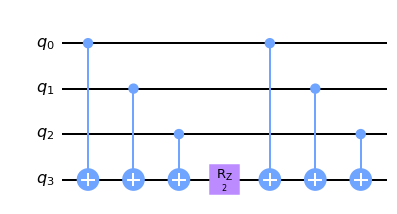

from which we can get the $U_{fh}$ as:

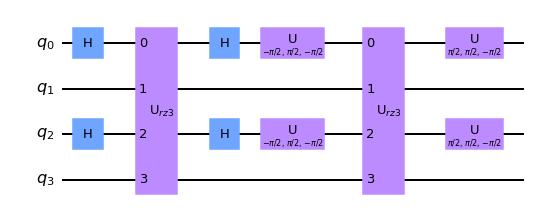

Notice that this gate requires 12 $CNOTs$.  Since 2-qubit gates errors are much larger than 1 qubit errors, the errors in $U_{fh}$ dominate our circuit.

We will come back to this.


## ...Ready for it? 

So first of, lets of course set up all the imports that we need:

* numpy
* import everything from qiskit
* import `matplotlib.pyplot` as plt
* Make sure you have $\pi$

In [2]:
import numpy as np
from qiskit import IBMQ, Aer, assemble, transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from numpy import pi
import matplotlib.pyplot as plt

Next, you neeed to load your IBMQ account, and set your provider to our `qjs-for-hep` project.  Finally, use the command

    provider.backends()
to look at all the computers 'available' to you (Note, 'ibmq_16_melbourne' isn't actually accessible)

Keep this list for later

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
provider.backends()

[<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_casablan

Copy over from yesterday your initalization of `N,epsilon`, and `mass`

In [4]:
# Number of sites
N = 2
epsilon = 0.5
mass = 1.0
eta = 1

## Gauge Kinetic Gate
Copy over your function for $RX(-\epsilon/2)$

In [5]:
def gauge_kinetic(epsilon):
    qc = QuantumCircuit(1)
    theta = -epsilon/2
    qc.rx(theta, 0)
    ukg = qc.to_gate()
    ukg.name = 'Rx'
    
    return ukg

## Fermion mass gate

Copy over your function for $RZ((-1)^{j+1}m\epsilon ) $

In [6]:
def fermion_mass(epsilon, mass, eta):
    qc = QuantumCircuit(1)
    qc.rz((-eta*mass*epsilon), [0])
    fm = qc.to_gate()
    fm.name = "Rz"
    
    return fm

## Fermion hopping term

Copy over your functions for $RZ3$ and $U_{fh}$

In [7]:
def rz3(theta):
    qc = QuantumCircuit(4)
    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)
    qc.rz(theta, 3)
    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)
    U_rz3 = qc.to_gate()
    U_rz3.name = "the complicated set of gates (urz3)"
    
    return U_rz3

In [8]:
def gross_gate(epsilon, eta):
    qc = QuantumCircuit(4)
    qc.h(0)
    qc.h(2)
    qubit_list = [0,1,2,3]
    U_rz3 = rz3((-epsilon)/(4*eta))
    qc.append(U_rz3, qubit_list)
    qc.h(0)
    qc.h(2)
    qc.u((-pi/2), (pi/2), (-pi/2), 0)
    qc.u((-pi/2), (pi/2), (-pi/2), 2)
    qc.append(U_rz3, qubit_list)
    qc.u((pi/2), (pi/2), (-pi/2), 0)
    qc.u((pi/2), (pi/2), (-pi/2), 2)
    grossgate = qc.to_gate()
    grossgate.name = "ufh"
    
    return grossgate

## Analysis functions: 

Copy over your functions `get_mean_fermion_number` and `get_bootstrap_error`

In [9]:
#define your function to take in a dictionary counts
def get_mean_fermion_number(counts):
    #first define a variable mean and set to 0
    mean = 0
    #define a variable total_counts = sum(counts.values())
    total_counts = sum(counts.values())
    #perform a for loop over the elements in counts, using for example `s` as the loop variable
    for s in counts:
        #define a variable p which is the last element of the identifier in your loop variable
        #i.e. p = s[-1]
        p = s[-1]
        #check if p is a `1`.
        if p == '1':
            #if p == '1', then add to mean counts[s]/total_counts
            mean += counts[s]/total_counts
    #return the mean       
    return mean    


In [10]:
#define a function `get_bootstrap_error(counts)` which takes in a dictionary `counts`
def get_bootstrap_error(counts):
    #compute the nshots by using sum(counts.values())
    nshots = sum(counts.values())
    #For our statistics, we will resample the distribution 100 times, so set B=100
    B = 100
    #Extract the list of unique keys in your dictionary and store them as a variable k via
    # k = list(counts.keys())
    k = list(counts.keys())
    #For each key, we need to define a probability list prob via [counts[a]/nshots for a in k]
    prob = [counts[a]/nshots for a in k]
    #define an empty array means
    means = []
    #With all this setup, now perform a for loop over b in range(B)
    for b in range(B):
        #set a variable m=0
        m = 0
        #build a new set of samples using numpy.random.choice with the arguments k, size=nshots, and p=prob
        #this function will return nshots worth of new results with probability prob from the choices in k
        samples = np.random.choice(k, size=nshots, p=prob)
        #make a for loop over s in the list samples
        for s in samples:
            #set a new variable p = s[-1] to again extract the number of electrons
            p = s[-1]
            #check if p = `1`
            if p == '1':
                #add 1/nshots to m if true
                m += 1/nshots
        #append the results of m to means
        means.append(m)
    #return from the function the standard deviation of means via numpy.std(means)   
    return np.std(means)

At this point, we have made all of the functions we need to run the code, and produce a time-evolution simulation.  So on to the main event:

* Define a bunch of empty list: `counts`, `sim_counts`, `means`, `errs`, `sim_means`, `sim_errs` and `Ts`
* Besides the above code, everything else should be within a for-loop in `T` over the `range(int(3/epsilon))` which will loop over the total integer time `T`.  The real total time is $\epsilon T$
* At the beginning of each step, append `T` to `Ts`
* Create a QuantumCircuit with enough qubits and classical bits to run using `fermion_hopping_opt2`.  Remember the number of fermions is stored as $N$, so the total number of qubits is $2N-1$.
* In order to do time-evolution of a state $|\psi(t)\rangle$, we need to define the initial state.  For us, lets use $H_0X_0|000\rangle$ as our initial state. The subscripts indicate which qubit the gates act on.
* Within the $T$ loop, we need another loop over $t$ which ranges from 0 to $T$.  This will be used to add the appropriate number of gates for the number of trotter steps $t$ taken.

Within the $t$ loop, you will need 3 loops:
 1. Loop over all fermions (Hint, this is not a simple range function but should step by 2). Appending to your circuit the fermion mass gate with parameters `epsilon`, `mass`, and for eta one should send in $(-1)^{n/2+1}$ where $n$ is the loop variable.
 2. Loop over all the photons (Hint, this is not a simple range function but should step by 2).  Append to your circuit `gauge_kinetic` with `epsilon`
 3. Loop over all electrons (Hint this loop should have the same step as the fermion loop, but should terminate 2 qubits earlier
 
 This completes time evolution.  Within your for-loop, you should set up a simulator and real machine backend, and run both together. Transpile them, and run.  Within the for-loop, add 
 
    sim_means.append(get_mean_fermion_number(sim_counts[T]))  
    means.append(get_mean_fermion_number(counts[T]))  
    
    sim_errs.append(get_bootstrap_error(sim_counts[T]))
    errs.append(get_bootstrap_error(counts[T]))
    
So that you can use that data to make plots and compare.  As a final thing, print out     `T*epsilon, sim_means[T], sim_errs[T], means[T], errs[T]` at each time step to get the numbers instantly. They should agree to some rough amount depending on your errors.

In [ ]:
# Define all of your empty arrays
counts, sim_counts, means, errs, sim_means, sim_errs, Ts = []
#Make the for loop
for T in range(int(3/epsilon)):
    #Append Ts and create your circuit
    Ts.append(T)
    qc.QuantumCircuit(3, 3)
    #state prep!
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.x(0)
    qc.x(1)
    qc.x(2)
    #time evolution
    for t in range(T):
    #add measurement steps
        #Loop over N fermions
        for n in range(0, 2*N, 2):
            fm = fermion_mass(epsilon, mass, (-1)**((n/2)+1))
            qc.append(fm, [n])
        #Loop over G photons
        for n in range(1, 2*N-1, 2):
            ukg = gauge_kinetic(epsilon)
            qc.append(ukg, [n])
        #Loop over N-2 electrons
        for n in range(0, 2*N-3, 2):
            
    #define your two backends
            
    #transpile your circuit for each backend

    #run each of your jobs, name them differently

    #append your results to sim_counts and counts.  Note that to access these later you will need counts[T] or sim_counts[T]

    #Compute the means and standard deviations and store them into the correct variables    
    
    
    #print out the time elapsed,means, and errors
    

At this point, contact a lab instructor to come check your code, because the last step is to extend the time step from $1/\epsilon$ to $3/\epsilon$.  This will require many more calls to the real device, so it could take a while.

After your done, run the next cell.  It should plot the simulator results vs the real device.  How did you do?  Do they agre e within errors everywhere?  Do they start getting worse?

<ErrorbarContainer object of 3 artists>

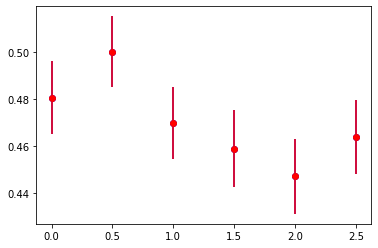

In [35]:
plt.errorbar(Ts, sim_means , yerr=sim_errs, ls='', marker='o', color='b')
plt.errorbar(Ts, means , yerr=errs, ls='', marker='o', color='r')